In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
import warnings

warnings.filterwarnings('ignore')

In [56]:
users = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1', parse_dates=['creation_time', 'last_session_creation_time'])
user_engagement = pd.read_csv('takehome_user_engagement.csv', encoding='ISO-8859-1', parse_dates=['time_stamp'])

In [57]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660,0,0,193,5240.0


In [58]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   object        
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 937.6+ KB


In [59]:
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [60]:
user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [61]:
data = pd.merge(users, user_engagement, left_on='object_id', right_on='user_id', how='left')

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211094 entries, 0 to 211093
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   object_id                   211094 non-null  int64         
 1   creation_time               211094 non-null  datetime64[ns]
 2   name                        211094 non-null  object        
 3   email                       211094 non-null  object        
 4   creation_source             211094 non-null  object        
 5   last_session_creation_time  207917 non-null  object        
 6   opted_in_to_mailing_list    211094 non-null  int64         
 7   enabled_for_marketing_drip  211094 non-null  int64         
 8   org_id                      211094 non-null  int64         
 9   invited_by_user_id          118528 non-null  float64       
 10  time_stamp                  207917 non-null  datetime64[ns]
 11  user_id                     207917 non-

In [63]:
data.isnull().sum()

object_id                         0
creation_time                     0
name                              0
email                             0
creation_source                   0
last_session_creation_time     3177
opted_in_to_mailing_list          0
enabled_for_marketing_drip        0
org_id                            0
invited_by_user_id            92566
time_stamp                     3177
user_id                        3177
visited                        3177
dtype: int64

The investigation reveals that there are 3,177 rows in the dataset where the columns last_session_creation_time, time_stamp, user_id, and visited are all missing simultaneously. This finding suggests that these missing values are interconnected, possibly representing users who have never logged in or for whom the login data was not recorded.

# Initial Assessment of Missing Values

In [64]:
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100

missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
missing_summary.sort_values(by='Percentage', ascending=False)

,Missing Values,Percentage
invited_by_user_id,92566,43.850607
last_session_creation_time,3177,1.505017
time_stamp,3177,1.505017
user_id,3177,1.505017
visited,3177,1.505017
object_id,0,0.000000
creation_time,0,0.000000
name,0,0.000000
email,0,0.000000
creation_source,0,0.000000


# Impute Missing Values and Investigate Further

In [65]:
# imputing missing values in 'invited_by_user_id' with -1 to indicate users were not invited by other users
data['invited_by_user_id'].fillna(-1, inplace=True)

# further investigation: last_session_creation_time, time_stamp, user_id, visited
# missing values are in the same rows
missing_columns = ['last_session_creation_time', 'time_stamp', 'user_id', 'visited']
missing_data = data[missing_columns]
missing_rows = missing_data[missing_data.isnull().any(axis=1)]

all_missing_count = missing_rows.shape[0]

investigation_summary = {
    'Total Missing Rows': missing_rows.shape[0],
    'Rows with All Columns Missing': all_missing_count
}

investigation_summary, missing_rows.head()


({'Total Missing Rows': 3177, 'Rows with All Columns Missing': 3177},
     last_session_creation_time time_stamp  user_id  visited
 20                         NaN        NaT      NaN      NaN
 21                         NaN        NaT      NaN      NaN
 307                        NaN        NaT      NaN      NaN
 310                        NaN        NaT      NaN      NaN
 311                        NaN        NaT      NaN      NaN)

# Remove Rows with Missing Login Data

In [66]:
# removing rows where 'last_session_creation_time', 'time_stamp', 'user_id', and 'visited' are all missing
data_cleaned = data.dropna(subset=['last_session_creation_time', 'time_stamp', 'user_id', 'visited'])

# checking the shape
original_shape = data.shape
cleaned_shape = data_cleaned.shape

original_shape, cleaned_shape

((211094, 13), (207917, 13))

# Define and Identify Adopted Users

In [67]:
data_cleaned['time_stamp'] = pd.to_datetime(data_cleaned['time_stamp']).dt.date

# Group by user 
grouped = data_cleaned.groupby('user_id')['time_stamp'].apply(lambda x: sorted(set(x)))

def is_adopted_user(logins):
    for i in range(len(logins) - 2):
        if logins[i + 2] - logins[i] <= timedelta(days=7):
            return True
    return False

adopted_users = grouped.apply(is_adopted_user)

adopted_users_count = adopted_users.sum()

adopted_users_count, adopted_users.head()

(1656,
 user_id
 1.0    False
 2.0     True
 3.0    False
 4.0    False
 5.0    False
 Name: time_stamp, dtype: bool)

# Exploratory Analysis and Visualization

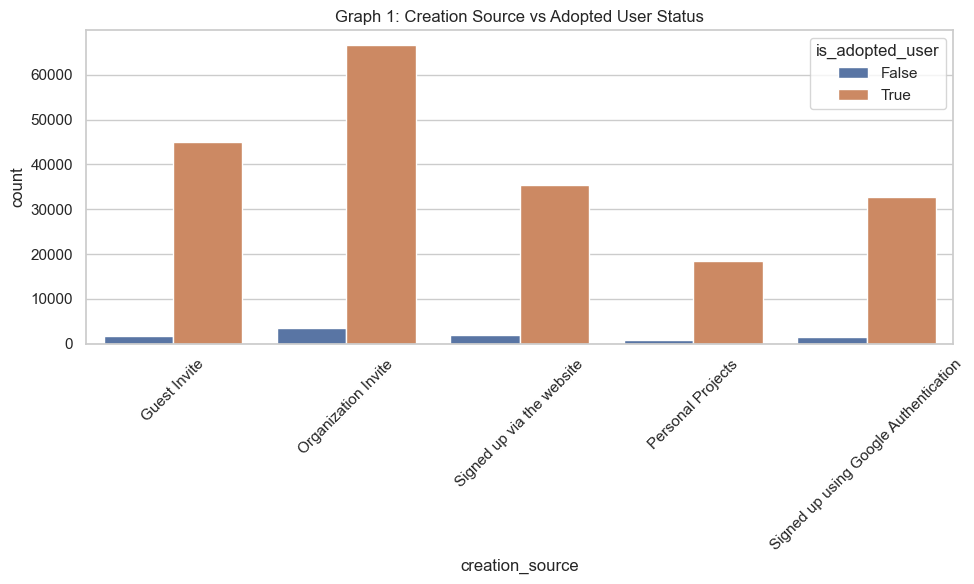

In [68]:
data_cleaned = data_cleaned.merge(adopted_users.rename('is_adopted_user'), on='user_id')

# Plot 
sns.set(style="whitegrid")

# Creation Source vs Adopted User
plt.figure(figsize=(10, 6))
sns.countplot(data=data_cleaned, x='creation_source', hue='is_adopted_user')
plt.title('Graph 1: Creation Source vs Adopted User Status')
plt.xticks(ticks=range(5), rotation=45, labels=[
    'Guest Invite',
    'Organization Invite',
    'Signed up via the website',
    'Personal Projects',
    'Signed up using Google Authentication'
])
plt.tight_layout()
plt.savefig('tab_1.png', bbox_inches='tight')  
plt.show()

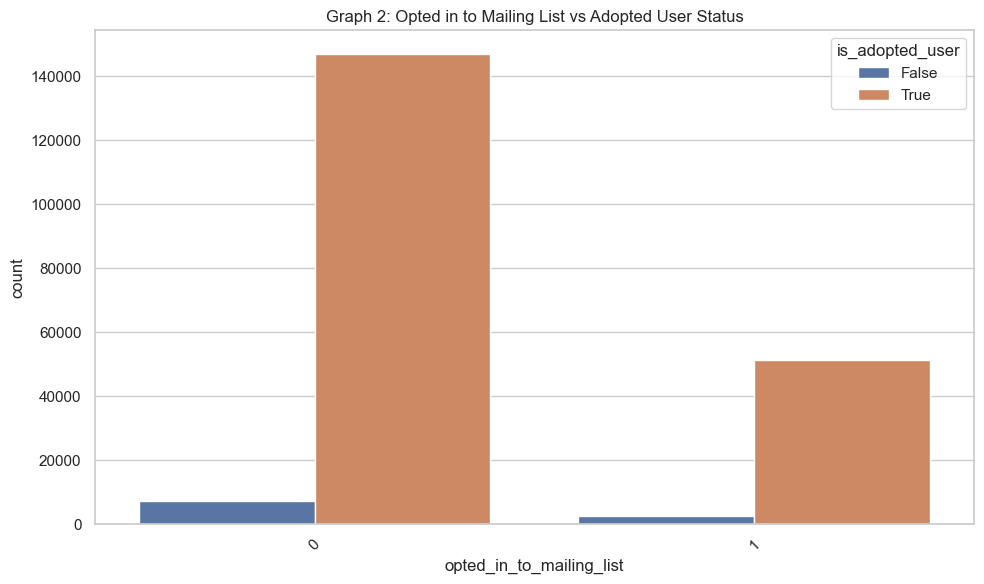

In [69]:
# Opted in to Mailing List vs Adopted User
plt.figure(figsize=(10, 6))
sns.countplot(data=data_cleaned, x='opted_in_to_mailing_list', hue='is_adopted_user')
plt.title('Graph 2: Opted in to Mailing List vs Adopted User Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('tab_2.png', bbox_inches='tight')  
plt.show()

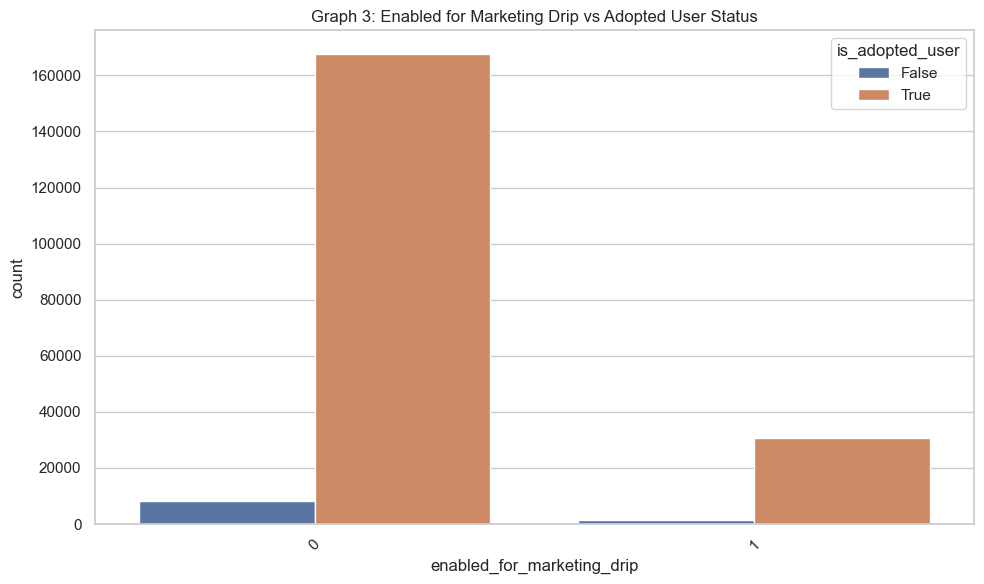

In [70]:
# Enabled for Marketing Drip vs Adopted User
plt.figure(figsize=(10, 6))
sns.countplot(data=data_cleaned, x='enabled_for_marketing_drip', hue='is_adopted_user')
plt.title('Graph 3: Enabled for Marketing Drip vs Adopted User Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('tab_3.png', bbox_inches='tight')  
plt.show()

# Logistic Regression Analysis

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Data Prep
# One-hot encoding 
encoder = OneHotEncoder(sparse=False)
encoded_creation_source = encoder.fit_transform(data_cleaned[['creation_source']])

# DF for encoded variables
encoded_creation_source_df = pd.DataFrame(encoded_creation_source, 
                                          columns=encoder.get_feature_names_out(['creation_source']))

# encoded variables with the original dataset
data_for_model = pd.concat([data_cleaned.reset_index(drop=True), encoded_creation_source_df], axis=1)

# features 
features = ['opted_in_to_mailing_list', 'enabled_for_marketing_drip'] + list(encoded_creation_source_df.columns)
X = data_for_model[features]
y = data_for_model['is_adopted_user']

# training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# predicting and evaluating the model
y_pred = log_reg.predict(X_test)
report = classification_report(y_test, y_pred)

# coefficients
coefficients = pd.DataFrame(log_reg.coef_[0], X.columns, columns=['Coefficient'])
coefficients['Odds Ratio'] = np.exp(coefficients['Coefficient'])

report, coefficients.sort_values(by='Odds Ratio', ascending=False)

('              precision    recall  f1-score   support\n\n       False       0.00      0.00      0.00      2909\n        True       0.95      1.00      0.98     59467\n\n    accuracy                           0.95     62376\n   macro avg       0.48      0.50      0.49     62376\nweighted avg       0.91      0.95      0.93     62376\n',
                                     Coefficient  Odds Ratio
 creation_source_GUEST_INVITE           0.157525    1.170611
 creation_source_SIGNUP_GOOGLE_AUTH     0.076848    1.079878
 opted_in_to_mailing_list               0.067178    1.069486
 creation_source_PERSONAL_PROJECTS      0.060154    1.062000
 enabled_for_marketing_drip            -0.008087    0.991946
 creation_source_ORG_INVITE            -0.097708    0.906913
 creation_source_SIGNUP                -0.198214    0.820194)